In [14]:
from netCDF4 import Dataset
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
import pickle

In [15]:
list_of_pits = pickle.load(open('../data/pit_info_roughness.p','rb'))

data_dir = '../data/kuka/required'


def get_code_from_name(x):
    
    s = x.split(' ')
    
    code = f'D{s[1]} SP{x[-1]}'
    
    return(code)

def speed(density,form):
    """ Return the radar speed from dry snow density
    density can be in g/cm3 or kg/m3
    form can be 'Ulaby','Hallikainen','Tiuri'
    string can be 'speed', 'factor' or 'wrongfactor'
    """
    c = 3e8
    if density > 10:
        density = density/1000
    speed_dict = {"Ulaby" : c*((1+0.51*density)**(-1.5)),
                  "Hallikainen":c*((1+1.91*density)**(-0.5)),
                  "Tiuri":c*((1+1.7*density + 0.7*density**2)**(-0.5))}
    return(speed_dict[form])

def get_time_ticks(times):
    seconds = [t.second for t in times]
    hours = [t.hour for t in times]
    minutes = [t.minute for t in times]
    time_ticks = [f'{h}:{str(m).zfill(2)}:{str(s).zfill(2)}' for h,m,s in zip(hours, minutes, seconds)]
    return time_ticks
    

def prepare_data(data_dict):
    all_data = {'ku':{},'ka':{}}

    for freq in ['ku','ka']:

        data_list = []
        time_ticks = []
        times = []

        for key, item in data_dict[freq].items():

            data_list.append(item['data'])

            time_ticks += item['time_ticks']
            times += item['times']

        full = np.concatenate(data_list,axis=1)

        all_data[freq] = {'full_data':full,
                          'time_ticks':time_ticks,
                          'times':times,
                         }
    
    return all_data
    
def get_time_index(time,times):
    
    deltas = np.array(times) - time

    secs = np.array([d.seconds for d in deltas])
    ms = np.array([d.microseconds for d in deltas])
    
    secs = secs + (ms * 1e-6)
    
    index = np.argmin(secs)
    
    return index


def get_range_index(input_range,ranges):
    
    deltas = np.array(ranges) - input_range
    
    index = np.argmin(np.abs(deltas))
    
    return index

def prepare_dicts(pit,pol):

    data_dict = {'ku':{},'ka':{}}

    freqranges = {}

    for fnames, freq in zip([pit['ku_f_names'], pit['ka_f_names']],
                            ['ku','ka']):
        for f in fnames:

#             d = Dataset(pit['dir']+'/'+f)

            with Dataset(data_dir+'/'+f) as d:
                data = np.asarray(d[f'{pol}_power_decon0'])
                times = [datetime.datetime(1970,1,1) + datetime.timedelta(seconds=float(s)) for s in d['start_time']]
                ranges = np.asarray(d['range'])
                time_ticks = get_time_ticks(times)

            data_dict[freq][f] = {'data':data,
                            'times':times,
                            'ranges':ranges,
                            'time_ticks':time_ticks}

            freqranges[freq]=ranges
            
    return (freqranges, data_dict)

    
def plot_lines(pit,
               scale='log',
               align_ka_peak=False,
               shift_ka_peak=False,
               xmin=1.3,
               xmax=2.5,
               normalise=False,
               r2_weighting=False,
               plot=True,
               title=True,
               pol='vv'):
    
    freqranges, data_dict = prepare_dicts(pit,pol)
    all_data = prepare_data(data_dict)

    argmaxs = {}
    maxs = {}
    
    return_dict = {}

    for freq in ['ku','ka']:
        
        range_diff=np.nan

        if scale == 'log':
            scan = np.log10(all_data[freq]['full_data'])
        elif scale == 'linear':
            scan = np.array(all_data[freq]['full_data'])
        else:
            raise
        
        time_begin = datetime.datetime.combine(pit['date'], datetime.time(hour=pit[f'{freq}_begin'][0],
                                                minute = pit[f'{freq}_begin'][1],
                                                second = pit[f'{freq}_begin'][2]))

        time_end = datetime.datetime.combine(pit['date'], datetime.time(hour=pit[f'{freq}_end'][0],
                                                minute = pit[f'{freq}_end'][1],
                                                second = pit[f'{freq}_end'][2]))


        start_index = get_time_index(time_begin,
                                     all_data[freq]['times'])
        end_index = get_time_index(time_end,
                                   all_data[freq]['times'])

        scan = scan[:,start_index:end_index]

        y_tick_spacing=7

        line = np.mean(scan,axis=1)

        line[freqranges[freq]<1] = np.nan
        line[freqranges[freq]>3] = np.nan

        if r2_weighting:
            line = np.divide(line,np.square(freqranges[freq]))
            
        argmaxs[freq] = np.nanargmax(line)
        max_power = np.nanmax(line)
        
        normline = line/abs(max_power)
        
        if normalise:
            line = normline
            

        ranges = freqranges[freq]
        
        if align_ka_peak and shift_ka_peak: raise
        
        if align_ka_peak & (freq == 'ka'):
            
            ku_norm = return_dict['ku_values']/abs(np.nanmax(return_dict['ku_values']))
            
            ku_thresh = np.argmax(ku_norm>0.1)
            ka_thresh = np.argmax(normline>0.1)

            ku_local_maxima = argrelextrema(ku_norm, np.greater)[0]
            ka_local_maxima = argrelextrema(normline, np.greater)[0]

            ku_nearest_max = return_dict['ku_ranges'][ku_local_maxima[np.argmin(np.abs(ku_local_maxima-ku_thresh))]]
            ka_nearest_max = ranges[ka_local_maxima[np.argmin(np.abs(ka_local_maxima-ka_thresh))]]
            
            return_dict['ku_first_max'] = ku_nearest_max
            
            range_diff = ka_nearest_max-ku_nearest_max

#             range_diff_old = (freqranges['ka'][argmaxs['ka']]-freqranges['ku'][argmaxs['ku']])
            
            ranges = freqranges[freq] - range_diff
        
        else:
            range_diff = 0
        
        if np.array(shift_ka_peak).any() & (freq == 'ka'):
        
            range_diff = shift_ka_peak
            ranges = freqranges[freq] - range_diff
        
        return_dict[f'{freq}_ranges'] = ranges
        return_dict[f'{freq}_values'] = line
        return_dict[f'{freq}_range_diff'] = range_diff
        
    return return_dict

yticks = list(np.round(np.arange(1,0,-0.2),decimals=1)) + list(np.round(np.arange(0,1.01,0.2),decimals=1))

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Day 5 SP2 natural 0
Day 5 SP2 ridged 0
Day 5 SP2 smooth 0


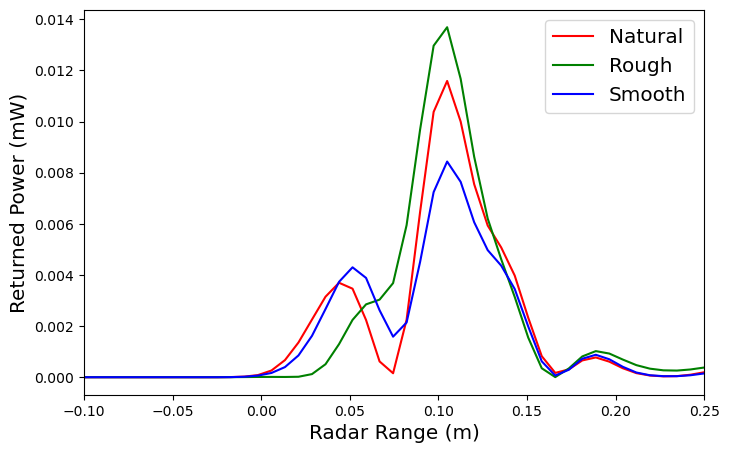

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

offsets = [0,0,0]
ls='-'

for pit,label,c,o in zip(list_of_pits.values(),
                  ['Natural','Rough','Smooth'],
                  ['r','g','b'],
                offsets):

    cp = plot_lines(pit,scale='linear',
               normalise=False,
                pol='vv',
#                 r2_weighting=True,
                plot=False,
                  )
    
    print(pit['name'],cp['ka_range_diff'])
    


    ax.plot(cp['ku_ranges']-1.5-o,
            cp['ku_values'],
            color=c,
            ls=ls,
            label=label)


    ax.set_xlim(-0.1,0.25)
    

    ax.legend(loc='upper right',fontsize='x-large')
    
    ax.set_ylabel('Returned Power (mW)',
                                   fontsize='x-large',va='bottom')

    ax.set_xlabel('Radar Range (m)',fontsize='x-large')


fig.subplots_adjust(wspace=0,hspace=0)

# plt.show()
plt.savefig(f'../figures/roughness.jpg',dpi=300,bbox_inches='tight')

#     plt.close()

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


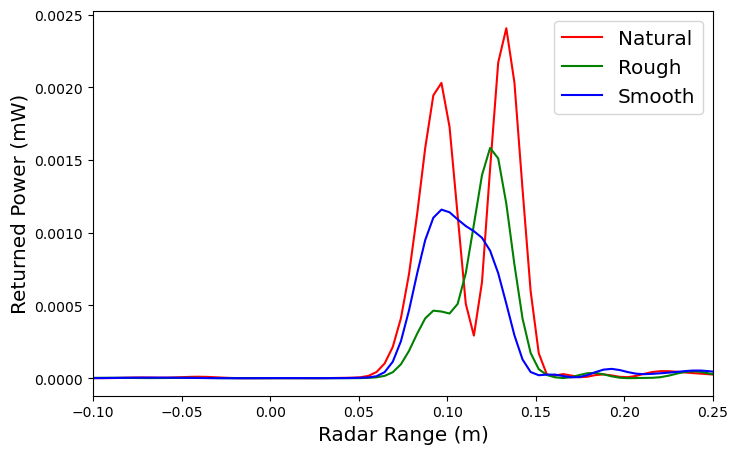

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

offsets = [0,0,0.0]

for pit,label,c,o in zip(list_of_pits.values(),
                  ['Natural','Rough','Smooth'],
                  ['r','g','b'],
                offsets):

    cp = plot_lines(pit,scale='linear',
               normalise=False,
                pol='vv',
#                 r2_weighting=True,
                plot=False,
                  )


    ax.plot(cp['ka_ranges']-1.5-o,
            cp['ka_values'],
            color=c,
            ls=ls,
            label=label)


    ax.set_xlim(-0.1,0.25)
    

    ax.legend(loc='upper right',fontsize='x-large')
    
    ax.set_ylabel('Returned Power (mW)',
                                   fontsize='x-large',va='bottom')

    ax.set_xlabel('Radar Range (m)',fontsize='x-large')


fig.subplots_adjust(wspace=0,hspace=0)

# plt.show()
# plt.savefig(f'../figures/roughness.jpg',dpi=300,bbox_inches='tight')

#     plt.close()

In [18]:
def plot_data(pit,pol,ymin=1.3,ymax=2):
    
    freqranges, data_dict = prepare_dicts(pit,pol)
    all_data = prepare_data(data_dict)

    ku_lims = {'y_start_ind' : get_range_index(ymin,freqranges['ku']), 
               'y_end_ind' : get_range_index(ymax,freqranges['ku'])}

    ka_lims = {'y_start_ind' : get_range_index(ymin,freqranges['ka']), 
               'y_end_ind' : get_range_index(ymax,freqranges['ka'])}

    lims = {'ku':ku_lims,'ka':ka_lims}

    y_tick_spacing = 40
    x_tick_spacing = 80

    x_start_time = all_data['ku']['times'][0]

    x_end_time = all_data['ku']['times'][-1]

    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,6))
    
    for ax, freq in zip([ax1,ax2],['ku','ka']):

        im = ax.imshow(np.log10(all_data[freq]['full_data']),aspect='auto')


        ax.set_yticks(np.arange(lims[freq]['y_start_ind'],lims[freq]['y_end_ind'],y_tick_spacing),
                  )

        ax.set_yticklabels(np.round(freqranges[freq][lims[freq]['y_start_ind']:lims[freq]['y_end_ind']:y_tick_spacing],
                       decimals=2))

        ax.set_ylim(lims[freq]['y_end_ind'],lims[freq]['y_start_ind'])

        ax.set_ylabel(f'Range ({freq}) (m)',fontsize='xx-large')

        ax.set_xticks(np.arange(0,len(all_data[freq]['times']),x_tick_spacing),
                  )

        ax.set_xticklabels(all_data[freq]['time_ticks'][0:len(all_data[freq]['times']):x_tick_spacing],
                                     rotation=90
        )

#         ax.set_xlabel('Time',fontsize='xx-large',position='top')

        if freq == 'ku':
            ax.tick_params('x',top=True,labeltop=True,labelbottom=False)
            
        cb = plt.colorbar(im,ax=ax)
        
        cb.set_label('Power (dBm)',fontsize='x-large')
            
    plt.show()




In [19]:
d = Dataset('../data/kuka/required/kuka_stare_decon_Ka-Scat20220422-152019.nc')
d

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: KuKa combined echo and summary data
    use_permission: Permission of project PI (Prof. Julienne Stroeve j.stroeve@ucl.ac.uk) is required to access, analyse and publish data before 1st January 2023. See MOSAiC Data Policy https://mosaic-expedition.org/wp-content/uploads/2020/12/mosaic_datapolicy.pdf.
    assistance: For data processing assistance, contact Dr. Rosemary Willatt (r.willatt@ucl.ac.uk) (Stare Mode), Dr. Vishnu Nandan (vishnu.nandan@umanitoba.ca) (Scan Mode), Dr Thomas Newman (t.newman@ucl.ac.uk) (Deconvolution)
    file_processed_with: KuKaPy translated from ProSensing IDL code by Vishnu Nandan with additions by Rosemary Willatt and Thomas Newman
    file_created_by: Willatt UCL
    date_created: 20220425
    data_type: KuKaPy output
    kuka_operators: Stefan Hendricks, Gunnar Spreen and Oguz Demir (leg 1), Julienne Stroeve, Vishnu Nandan, Rasmus Tonboe and Marcus Huntemann (le

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoi

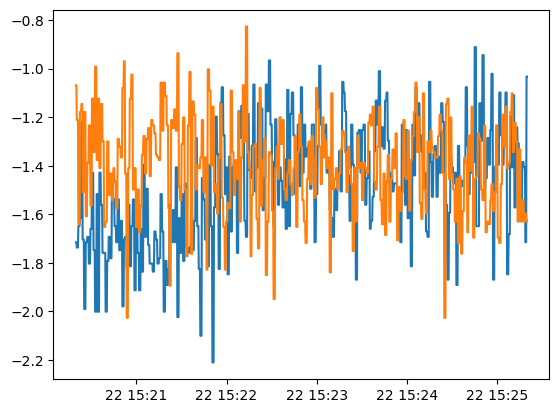

In [20]:
times = [datetime.datetime(1970,1,1) + datetime.timedelta(seconds=float(s)) for s in d['start_time']]

plt.plot(times,np.array(d['along_tilt']))
plt.plot(times,np.array(d['cross_tilt']))

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


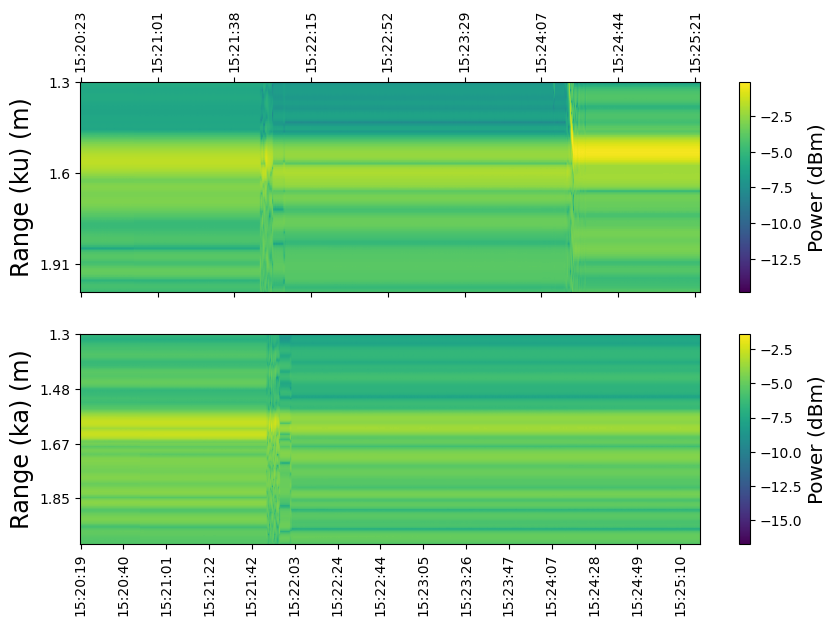

In [21]:
plot_data(list_of_pits['D5 SP2'],pol='vv')

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


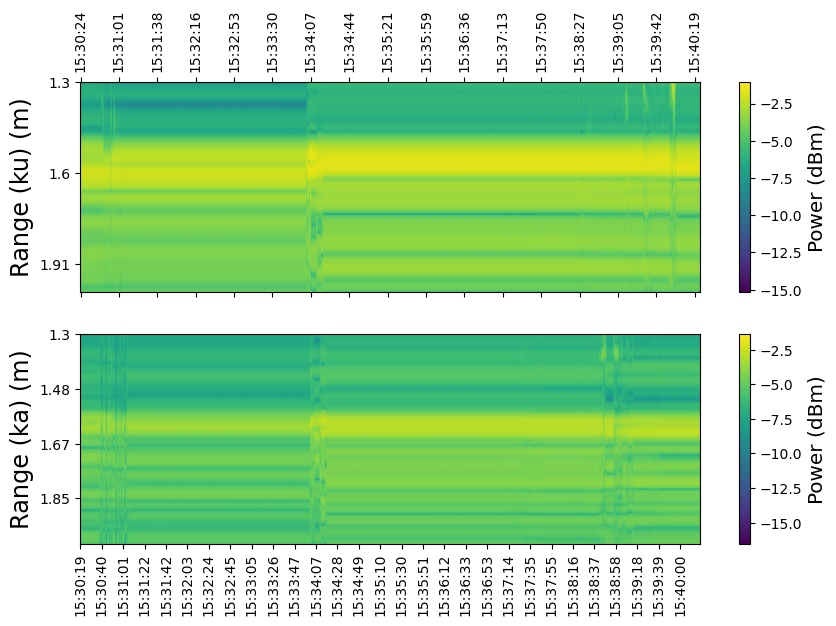

In [22]:
plot_data(list_of_pits['D5 SP2S'],pol='vv')

In [39]:
list_of_pits

{'D5 SP2': {'dir': 'PS129_kuka',
  'name': 'Day 5 SP2 natural',
  'code': 'D5 SP2',
  'date': datetime.date(2022, 4, 22),
  'ku_f_names': ['kuka_stare_decon_Ku-Scat20220422-152023.nc'],
  'ka_f_names': ['kuka_stare_decon_Ka-Scat20220422-152019.nc'],
  'ka_begin': (15, 20, 30),
  'ka_end': (15, 21, 30),
  'ku_begin': (15, 22, 0),
  'ku_end': (15, 23, 0)},
 'D5 SP2R': {'dir': 'PS129_kuka',
  'name': 'Day 5 SP2 ridged',
  'code': 'D5 SP2R',
  'date': datetime.date(2022, 4, 22),
  'ku_f_names': ['kuka_stare_decon_Ku-Scat20220422-154025.nc'],
  'ka_f_names': ['kuka_stare_decon_Ka-Scat20220422-154020.nc'],
  'ka_begin': (15, 41, 0),
  'ka_end': (15, 42, 0),
  'ku_begin': (15, 43, 30),
  'ku_end': (15, 44, 30)},
 'D5 SP2S': {'dir': 'PS129_kuka',
  'name': 'Day 5 SP2 smooth',
  'code': 'D5 SP2S',
  'date': datetime.date(2022, 4, 22),
  'ku_f_names': ['kuka_stare_decon_Ku-Scat20220422-153024.nc',
   'kuka_stare_decon_Ku-Scat20220422-153524.nc'],
  'ka_f_names': ['kuka_stare_decon_Ka-Scat2022042

In [42]:
# list_of_pits['D5 SP2'] = {'dir':'PS129_kuka',
#          'name':'Day 5 SP2 natural',
#          'code':'D5 SP2',
#          'date':datetime.date(2022,4,22),
#          'ku_f_names':[
#             'kuka_stare_decon_Ku-Scat20220422-152023.nc',
#             ],
#          'ka_f_names':[
#             'kuka_stare_decon_Ka-Scat20220422-152019.nc',
#             ],
#           'ka_begin':(15,22,30),
#           'ka_end':(15,23,30),
#           'ku_begin':(15,22,0),
#           'ku_end':(15,23,0),
#         }